<a href="https://colab.research.google.com/github/Zejabati/Viralityt_of_Tweet/blob/main/Virality%20of%20Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier

from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from datetime import date
from google.colab import files

In [84]:
df = pd.read_json('Train Data.json', lines=True)
df.head()

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,withheld_in_countries
0,2018-07-31 13:34:40+00:00,1024287229525598210,1024287229525598208,RT @KWWLStormTrack7: We are more than a month ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-07-31 13:34:40+00:00,1024287229512953856,1024287229512953856,@hail_ee23 Thanks love its just the feeling of...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.024128e+18,1.024128e+18,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-07-31 13:34:40+00:00,1024287229504569344,1024287229504569344,RT @TransMediaWatch: Pink News has more on the...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,0,False,False,en,0.0,NaN,NaN,NaN,NaN,NaN
3,2018-07-31 13:34:40+00:00,1024287229496029190,1024287229496029184,RT @realDonaldTrump: One of the reasons we nee...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-07-31 13:34:40+00:00,1024287229492031490,1024287229492031488,RT @First5App: This hearing of His Word doesn’...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
null_counts = df.isnull().sum()
#null
print(null_counts[null_counts > 0].sort_values(ascending=False))

contributors                 11099
withheld_in_countries        11097
geo                          11082
coordinates                  11082
place                        10943
quoted_status                10772
quoted_status_id              9945
quoted_status_id_str          9945
extended_entities             9900
in_reply_to_status_id         9697
in_reply_to_status_id_str     9697
in_reply_to_user_id           9596
in_reply_to_user_id_str       9596
in_reply_to_screen_name       9596
possibly_sensitive            7907
retweeted_status              3727
dtype: int64


In [86]:
#percent
print((null_counts[null_counts > 0].sort_values(ascending=False)/len(df))*100)

contributors                 100.000000
withheld_in_countries         99.981980
geo                           99.846833
coordinates                   99.846833
place                         98.594468
quoted_status                 97.053789
quoted_status_id              89.602667
quoted_status_id_str          89.602667
extended_entities             89.197225
in_reply_to_status_id         87.368231
in_reply_to_status_id_str     87.368231
in_reply_to_user_id           86.458239
in_reply_to_user_id_str       86.458239
in_reply_to_screen_name       86.458239
possibly_sensitive            71.240652
retweeted_status              33.579602
dtype: float64


In [87]:
median_retweets = np.median(df['retweet_count'])
df['is_viral'] = np.where(df['retweet_count'] >= median_retweets, 1, 0)

df['tweet_length'] = df.apply(lambda tweet: len(tweet['text']), axis=1)
df['followers_count'] = df.apply(lambda tweet: tweet['user']['followers_count'], axis=1)
df['friends_count'] = df.apply(lambda tweet: tweet['user']['friends_count'], axis=1)
df['favourites_count'] = df.apply(lambda tweet: tweet['user']['favourites_count'], axis=1)
df['statuses_count'] = df.apply(lambda tweet: tweet['user']['statuses_count'], axis=1)
df['listed_count']= df.apply(lambda tweet: tweet['user']['listed_count'], axis=1)
df['hashtag_count'] = df.apply(lambda tweet: tweet['text'].count('#'), axis=1)
df['http_count']= df.apply(lambda tweet: tweet['text'].count('http'), axis=1)
df['sign']= df.apply(lambda tweet: tweet['text'].count('@'),axis=1)
df['verified']= df.apply(lambda tweet: tweet['user']['verified'], axis=1)

In [88]:
def month_converter(month):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return months.index(month) + 1

In [89]:
df['Days_count']=0

df['date']=df.user.apply(lambda x:x['created_at'].split( ))
for i in range(len(df['date'])):
  df['date'][i][1]=month_converter(df['date'][i][1])

w=len(df['date'])
Matrix = [[0 for x in range(3)] for y in range(w)]
d= date(2020, 7, 7)
for i in range(len(df['date'])):
  Matrix[i][0] = int(df['date'][i][5])
  Matrix[i][1] = int(df['date'][i][1])
  Matrix[i][2] = int(df['date'][i][2])
  df['Days_count'][i]=(d-date(Matrix[i][0],Matrix[i][1],Matrix[i][2])).days

<ipython-input-89-6f6eb7250377>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Days_count'][i]=(d-date(Matrix[i][0],Matrix[i][1],Matrix[i][2])).days


**Define x , y**

In [90]:
y = df['is_viral']
x = df[['tweet_length' , 'followers_count', 'friends_count','favourites_count','statuses_count',
        'hashtag_count', 'http_count', 'sign', 'verified','listed_count','Days_count','truncated']]


**Describe Data**

In [91]:
x.head()

,tweet_length,followers_count,friends_count,favourites_count,statuses_count,hashtag_count,http_count,sign,verified,listed_count,Days_count,truncated
0,140,215,335,3419,4475,0,0,1,False,2,3703,False
1,77,199,203,2136,3922,0,0,1,False,1,2308,False
2,140,196,558,62560,11546,0,0,1,False,0,1046,False
3,140,3313,2272,51818,26609,0,0,1,False,41,4138,False
4,140,125,273,1332,519,0,0,1,False,3,2795,False


In [92]:
print(x.shape)
print(x.columns)
x.describe()

(11099, 12)
Index(['tweet_length', 'followers_count', 'friends_count', 'favourites_count',
       'statuses_count', 'hashtag_count', 'http_count', 'sign', 'verified',
       'listed_count', 'Days_count', 'truncated'],
      dtype='object')


,tweet_length,followers_count,friends_count,favourites_count,statuses_count,hashtag_count,http_count,sign,listed_count,Days_count
count,11099.000000,1.109900e+04,11099.000000,11099.000000,1.109900e+04,11099.000000,11099.000000,11099.000000,11099.000000,11099.000000
mean,122.833589,6.009168e+03,1442.336337,19413.978286,3.476254e+04,0.232543,0.412379,1.085233,47.017479,2376.525813
std,27.850477,2.013144e+05,7645.949991,39144.906425,8.879138e+04,0.725709,0.525913,0.970616,254.953725,1120.136156
min,9.000000,0.000000e+00,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,707.000000
25%,110.000000,1.310000e+02,194.000000,1052.000000,2.543000e+03,0.000000,0.000000,1.000000,0.000000,1300.000000
50%,140.000000,4.030000e+02,442.000000,5538.000000,9.943000e+03,0.000000,0.000000,1.000000,3.000000,2386.000000
75%,140.000000,1.249000e+03,1116.000000,19576.500000,3.418700e+04,0.000000,1.000000,1.000000,19.000000,3319.000000
max,155.000000,2.021186e+07,510292.000000,635920.000000,2.848360e+06,10.000000,4.000000,12.000000,12895.000000,4977.000000


<Axes: >

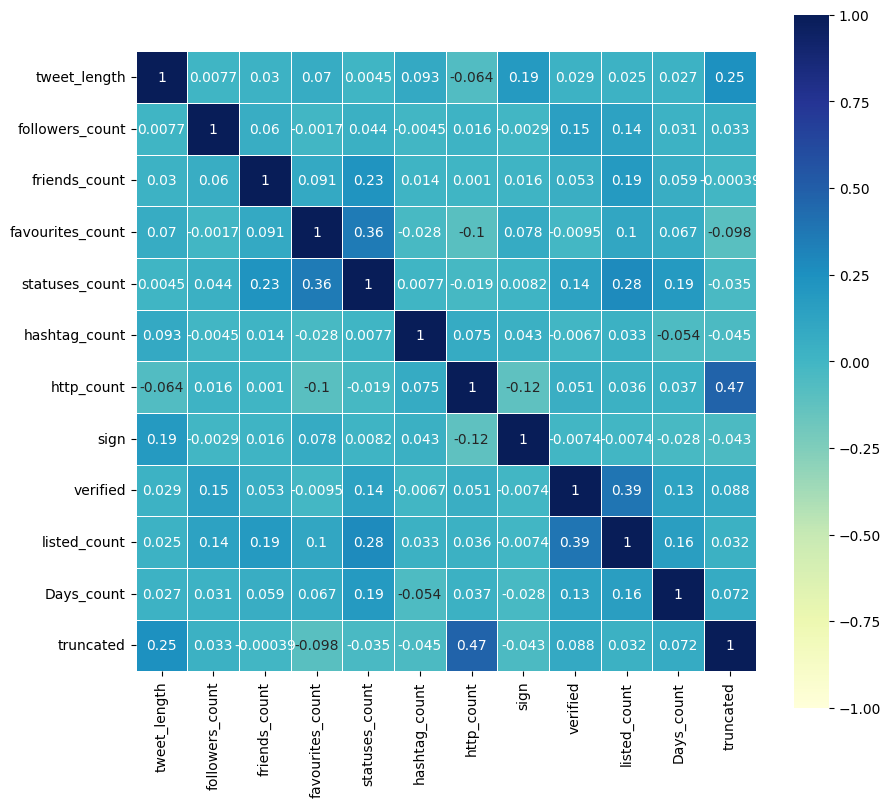

In [93]:
f, ax = plt.subplots(figsize = [10,9])
sns.heatmap(x.corr(),linewidths = .5, annot = True, cmap = 'YlGnBu', square = True, vmin=-1, vmax=1)

<Figure size 640x480 with 0 Axes>

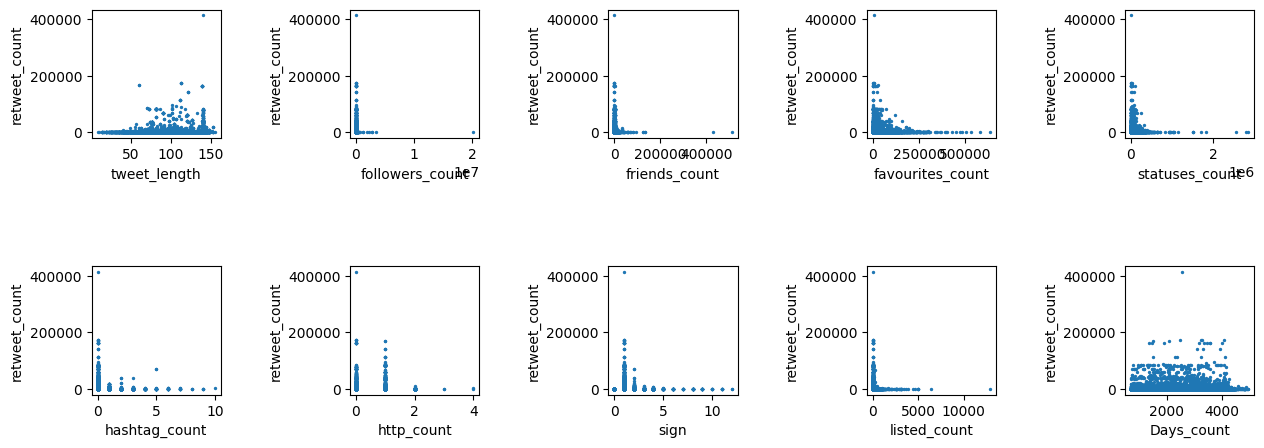

In [94]:
list_columns=['tweet_length', 'followers_count', 'friends_count', 'favourites_count',
       'statuses_count', 'hashtag_count', 'http_count', 'sign','listed_count', 'Days_count']

fig = plt.figure()
fig, axs = plt.subplots(2,5,figsize=(15,5))
plt.subplots_adjust(wspace=1,hspace=1)

for i in range(1,11):
  plt.subplot(2, 5, i)
  plt.scatter(x[list_columns[i-1]],df['retweet_count'],s=2)
  plt.xlabel(list_columns[i-1])
  plt.ylabel('retweet_count')

plt.show()

In [95]:
null_counts = x.isnull().sum()
#null
print(null_counts[null_counts > 0].sort_values(ascending=False))
#percent
print((null_counts[null_counts > 0].sort_values(ascending=False)/len(x))*100)

Series([], dtype: int64)
Series([], dtype: float64)


In [96]:
x_boxplot=x.copy()

In [97]:
non_numerical_columns = ['verified','truncated']

for i in non_numerical_columns:
    x1 = pd.get_dummies(x[i])
    x = x.join(x1,lsuffix='_l',rsuffix='_r')
    x.drop(i,axis=1,inplace=True)

In [98]:
data=x.copy()
data['is_viral']=y

In [99]:
x.head()

,tweet_length,followers_count,friends_count,favourites_count,statuses_count,hashtag_count,http_count,sign,listed_count,Days_count,False_l,True_l,False_r,True_r
0,140,215,335,3419,4475,0,0,1,2,3703,1,0,1,0
1,77,199,203,2136,3922,0,0,1,1,2308,1,0,1,0
2,140,196,558,62560,11546,0,0,1,0,1046,1,0,1,0
3,140,3313,2272,51818,26609,0,0,1,41,4138,1,0,1,0
4,140,125,273,1332,519,0,0,1,3,2795,1,0,1,0


In [100]:
x.columns

Index(['tweet_length', 'followers_count', 'friends_count', 'favourites_count',
       'statuses_count', 'hashtag_count', 'http_count', 'sign', 'listed_count',
       'Days_count', 'False_l', 'True_l', 'False_r', 'True_r'],
      dtype='object')

In [101]:
x_scaled = StandardScaler().fit_transform(x)
x_scaled=pd.DataFrame(x_scaled)
x_scaled.columns =['tweet_length',  'followers_count','friends_count','favourites_count','statuses_count','hashtag_count',
             'http_count', 'sign','listed_count','Days_count','False_l', 'True_l', 'False_r', 'True_r']
x_scaled.head()

,tweet_length,followers_count,friends_count,favourites_count,statuses_count,hashtag_count,http_count,sign,listed_count,Days_count,False_l,True_l,False_r,True_r
0,0.616405,-0.028783,-0.144833,-0.408628,-0.341124,-0.320451,-0.784156,-0.087817,-0.176579,1.184261,0.126569,-0.126569,0.411611,-0.411611
1,-1.645776,-0.028862,-0.162098,-0.441405,-0.347353,-0.320451,-0.784156,-0.087817,-0.180502,-0.061179,0.126569,-0.126569,0.411611,-0.411611
2,0.616405,-0.028877,-0.115666,1.102263,-0.261485,-0.320451,-0.784156,-0.087817,-0.184424,-1.187879,0.126569,-0.126569,0.411611,-0.411611
3,0.616405,-0.013393,0.108515,0.827834,-0.091832,-0.320451,-0.784156,-0.087817,-0.023603,1.572624,0.126569,-0.126569,0.411611,-0.411611
4,0.616405,-0.029230,-0.152942,-0.461945,-0.385680,-0.320451,-0.784156,-0.087817,-0.172657,0.373609,0.126569,-0.126569,0.411611,-0.411611


**Detecting Outliers usind DBSCAN**

In [102]:
A = []
B = []
C = []

for i in np.linspace(0.1,5,30):
    db = DBSCAN(eps=i, min_samples=3).fit(x_scaled)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    sum = 0
    for t in labels:
        if t == -1:
            sum = sum + 1
            sumpercent=(sum/len(x_scaled))*100
    C.append(sumpercent)
    A.append(i)
    B.append(int(n_clusters_))

Text(0.5, 1.0, 'Percent of outliers/distance')

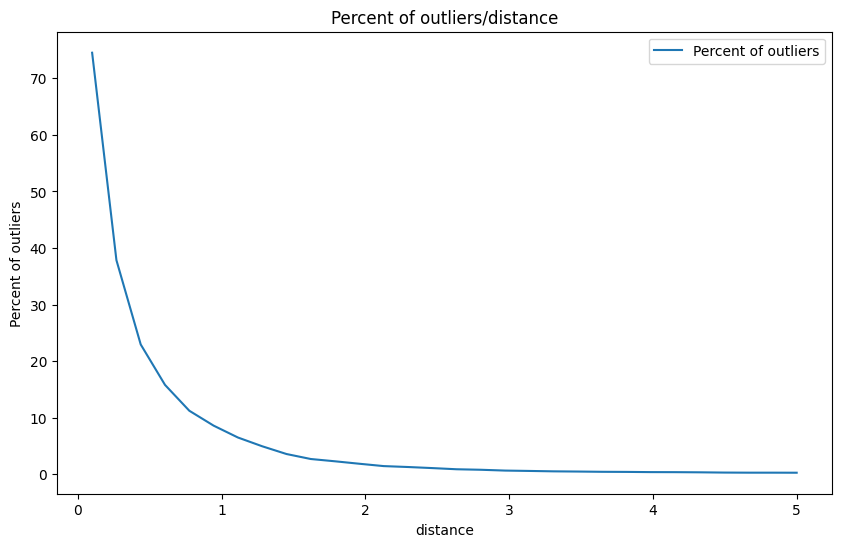

In [103]:
results = pd.DataFrame([A,B,C]).T
results.columns = ['distance','Number of clusters','Percent of outliers']
ax=results.plot(x='distance',y='Percent of outliers',figsize=(10,6),)
ax.set_xlabel('distance')
ax.set_ylabel('Percent of outliers')
ax.set_title('Percent of outliers/distance')


In [104]:
M=1000
for i in range(len(C)):
  if 3<=C[i]<=4 and M==1000:
    eps=A[i]
    M=0
print(eps)

1.4517241379310346


In [105]:
x_scaled.shape

(11099, 14)

In [106]:
clustering = DBSCAN(eps=eps, min_samples=3).fit(x_scaled)
predict = clustering.labels_
#list(predict).count(-1)
x_scaled = x_scaled[~np.where(predict == -1, True, False)]
y = y[~np.where(predict == -1, True, False)]

In [107]:
x_scaled.shape

(10701, 14)

**Detecting Outlier using Boxplot**

In [108]:
data.head()


,tweet_length,followers_count,friends_count,favourites_count,statuses_count,hashtag_count,http_count,sign,listed_count,Days_count,False_l,True_l,False_r,True_r,is_viral
0,140,215,335,3419,4475,0,0,1,2,3703,1,0,1,0,0
1,77,199,203,2136,3922,0,0,1,1,2308,1,0,1,0,0
2,140,196,558,62560,11546,0,0,1,0,1046,1,0,1,0,0
3,140,3313,2272,51818,26609,0,0,1,41,4138,1,0,1,0,1
4,140,125,273,1332,519,0,0,1,3,2795,1,0,1,0,0


In [109]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

print((data< (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR)))

tweet_length           30.0
followers_count      1118.0
friends_count         922.0
favourites_count    18524.5
statuses_count      31644.0
hashtag_count           0.0
http_count              1.0
sign                    0.0
listed_count           19.0
Days_count           2019.0
False_l                 0.0
True_l                  0.0
False_r                 0.0
True_r                  0.0
is_viral                1.0
dtype: float64
       tweet_length  followers_count  friends_count  favourites_count  \
0             False            False          False             False   
1             False            False          False             False   
2             False            False          False              True   
3             False             True          False              True   
4             False            False          False             False   
...             ...              ...            ...               ...   
11094         False            False          False   

In [110]:
x_boxplot.head()

,tweet_length,followers_count,friends_count,favourites_count,statuses_count,hashtag_count,http_count,sign,verified,listed_count,Days_count,truncated
0,140,215,335,3419,4475,0,0,1,False,2,3703,False
1,77,199,203,2136,3922,0,0,1,False,1,2308,False
2,140,196,558,62560,11546,0,0,1,False,0,1046,False
3,140,3313,2272,51818,26609,0,0,1,False,41,4138,False
4,140,125,273,1332,519,0,0,1,False,3,2795,False


In [111]:
continous=x_boxplot.drop(columns=['verified','truncated'])
x_out = continous[~((continous < (Q1 - 1.5 * IQR)) |(continous > (Q3 + 1.5 * IQR))).any(axis=1)]
print(x_out.shape)

(4234, 10)


<ipython-input-111-30413c4a085c>:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  x_out = continous[~((continous < (Q1 - 1.5 * IQR)) |(continous > (Q3 + 1.5 * IQR))).any(axis=1)]


**Decision Tree**

In [112]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
print(x_scaled.shape)
x_scaled.head()

(10701, 14)


,tweet_length,followers_count,friends_count,favourites_count,statuses_count,hashtag_count,http_count,sign,listed_count,Days_count,False_l,True_l,False_r,True_r
0,0.616405,-0.028783,-0.144833,-0.408628,-0.341124,-0.320451,-0.784156,-0.087817,-0.176579,1.184261,0.126569,-0.126569,0.411611,-0.411611
1,-1.645776,-0.028862,-0.162098,-0.441405,-0.347353,-0.320451,-0.784156,-0.087817,-0.180502,-0.061179,0.126569,-0.126569,0.411611,-0.411611
2,0.616405,-0.028877,-0.115666,1.102263,-0.261485,-0.320451,-0.784156,-0.087817,-0.184424,-1.187879,0.126569,-0.126569,0.411611,-0.411611
3,0.616405,-0.013393,0.108515,0.827834,-0.091832,-0.320451,-0.784156,-0.087817,-0.023603,1.572624,0.126569,-0.126569,0.411611,-0.411611
4,0.616405,-0.029230,-0.152942,-0.461945,-0.385680,-0.320451,-0.784156,-0.087817,-0.172657,0.373609,0.126569,-0.126569,0.411611,-0.411611


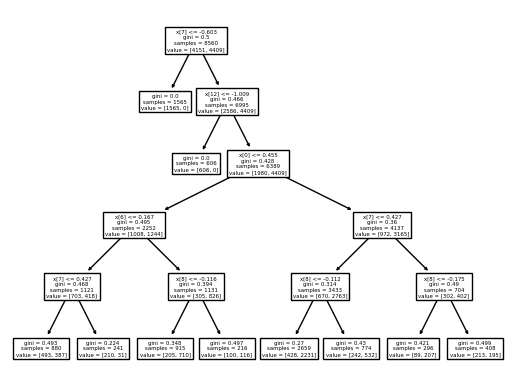

accuracy: 0.8014946286781878
recall: 0.8760484622553588
precision: 0.762987012987013
f1_score: 0.8156182212581344
confusion_matrix: 
 [[776 292]
 [133 940]]


In [113]:
dectree = tree.DecisionTreeClassifier(max_depth=5)
dectree.fit(X_train, y_train)
tree.plot_tree(dectree.fit(X_train, y_train))
plt.show()

print('accuracy:',dectree.score(X_test, y_test))
print('recall:',recall_score(y_test, dectree.predict(X_test)))
print('precision:',precision_score(y_test, dectree.predict(X_test)))
print('f1_score:',f1_score(y_test, dectree.predict(X_test)))
print('confusion_matrix:','\n',confusion_matrix(y_test, dectree.predict(X_test)))

best parameter: max_depth: 8


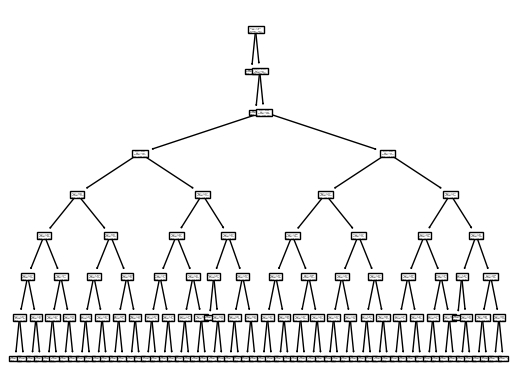

accuracy: 0.7991592713685194
recall: 0.8909599254426841
precision: 0.7533490937746257
f1_score: 0.816396242527754
confusion_matrix: 
 [[755 313]
 [117 956]]


In [114]:
score_dectree = []
for i in np.arange(3, 15, 1):
  dectree = tree.DecisionTreeClassifier(max_depth=i)
  dectree.fit(X_train, y_train)
  score_dectree.append([i, np.mean(cross_val_score(dectree, X_train, y_train,scoring='accuracy',cv=5))])

score_dectree = pd.DataFrame(score_dectree)
score_dectree = score_dectree.sort_values(by=1, ascending=False).reset_index()
i=score_dectree[0][0]
print('best parameter:','max_depth:',i)

dectree = tree.DecisionTreeClassifier(max_depth=i)
dectree.fit(X_train, y_train)
tree.plot_tree(dectree.fit(X_train, y_train))
plt.show()
print('accuracy:',dectree.score(X_test, y_test))
print('recall:',recall_score(y_test, dectree.predict(X_test)))
print('precision:',precision_score(y_test, dectree.predict(X_test)))
print('f1_score:',f1_score(y_test, dectree.predict(X_test)))
print('confusion_matrix:','\n',confusion_matrix(y_test, dectree.predict(X_test)))

**Bagging**

In [115]:
bag = BaggingClassifier(n_estimators=100)
bag.fit(X_train, y_train)

print('accuracy:',bag.score(X_test, y_test))
print('recall:',recall_score(y_test, bag.predict(X_test)))
print('precision:',precision_score(y_test, bag.predict(X_test)))
print('f1_score:',f1_score(y_test, bag.predict(X_test)))
print('confusion_matrix:','\n',confusion_matrix(y_test, bag.predict(X_test)))

accuracy: 0.8234469873890705
recall: 0.896551724137931
precision: 0.7827502034174125
f1_score: 0.8357949609035621
confusion_matrix: 
 [[801 267]
 [111 962]]


In [116]:
score_bag = []
for i in np.arange(5, 110, 5):
  bag = BaggingClassifier(n_estimators=i)
  bag.fit(X_train, y_train)
  score_bag.append([i, np.mean(cross_val_score(bag , X_train, y_train,scoring='accuracy',cv=5))])

score_bag = pd.DataFrame(score_bag)
score_bag = score_bag.sort_values(by=1, ascending=False).reset_index()
i=score_bag[0][0]
print('best parameter:','n_estimators:',i)
bag = BaggingClassifier(n_estimators=i)
bag.fit(X_train, y_train)

print('accuracy:',bag.score(X_test, y_test))
print('recall:',recall_score(y_test, bag.predict(X_test)))
print('precision:',precision_score(y_test, bag.predict(X_test)))
print('f1_score:',f1_score(y_test, bag.predict(X_test)))
print('confusion_matrix:','\n',confusion_matrix(y_test, bag.predict(X_test)))

best parameter: n_estimators: 105
accuracy: 0.8243811303129379
recall: 0.9030754892823858
precision: 0.7808219178082192
f1_score: 0.8375108038029386
confusion_matrix: 
 [[796 272]
 [104 969]]


**Random Forest**

In [117]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

print('accuracy:',rf.score(X_test, y_test))
print('recall:',recall_score(y_test, rf.predict(X_test)))
print('precision:',precision_score(y_test, rf.predict(X_test)))
print('f1_score:',f1_score(y_test, rf.predict(X_test)))
print('confusion_matrix:','\n',confusion_matrix(y_test, rf.predict(X_test)))

accuracy: 0.8229799159271368
recall: 0.9049394221808015
precision: 0.7780448717948718
f1_score: 0.8367083153813011
confusion_matrix: 
 [[791 277]
 [102 971]]


In [118]:
score_rf = []
max_features = ['auto', 'sqrt']

for i in np.arange(100, 501, 100):
  for j in np.arange(5, 21 , 5):
    for k in max_features:
      rf = RandomForestClassifier()
      rf.fit(X_train, y_train)
      score_rf.append([i, j, k, np.mean(cross_val_score(rf, X_train, y_train, scoring='accuracy',cv=5))])

score_rf = pd.DataFrame(score_rf)
score_rf = score_rf.sort_values(by=3, ascending=False).reset_index()
i=score_rf[0][0]
j=score_rf[1][0]
k=score_rf[2][0]
print('best parameters:','n_estimators:',i ,'max_depth:',j ,'max_features:',k)

rf = RandomForestClassifier(n_estimators=i, max_depth=j, max_features=k)
rf.fit(X_train,y_train)

print('accuracy:',rf.score(X_test, y_test))
print('recall:',recall_score(y_test, rf.predict(X_test)))
print('precision:',precision_score(y_test, rf.predict(X_test)))
print('f1_score:',f1_score(y_test, rf.predict(X_test)))
print('confusion_matrix:','\n',confusion_matrix(y_test, rf.predict(X_test)))

best parameters: n_estimators: 400 max_depth: 20 max_features: auto


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


accuracy: 0.8257823446987389
recall: 0.9226467847157502
precision: 0.7734375
f1_score: 0.8414789630259243
confusion_matrix: 
 [[778 290]
 [ 83 990]]


In [119]:
df_test = pd.read_json('Test_Data.json', lines=True)
df_test.head()

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,withheld_in_countries
0,2018-07-31 13:34:18,1024287138433691650,1024287138433691648,RT @Rschooley: Has anyone been held to the Al ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,0,False,False,en,NaN,NaN,NaN,None,None,None
1,2018-07-31 13:34:13,1024287116241641473,1024287116241641472,RT @seuIsgis: when red flavor comes on shuffle...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,0,False,False,en,0.0,NaN,NaN,"{'media': [{'id': 1023603946344960002, 'id_str...",None,None
2,2018-07-31 13:34:24,1024287163637092354,1024287163637092352,the world is his runway https://t.co/3sLst44JOT,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,0,False,False,en,0.0,NaN,NaN,"{'media': [{'id': 1024282644933095426, 'id_str...",None,None
3,2018-07-31 13:34:26,1024287169861509120,1024287169861509120,RT @lexie_marie5: 12:46 AM and I cannot stop t...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,0,False,False,en,NaN,NaN,NaN,None,None,None
4,2018-07-31 13:34:35,1024287208772198400,1024287208772198400,@RationalPanic No surprise at what the council...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.023992e+18,1.023992e+18,...,0,False,False,en,NaN,NaN,NaN,None,None,None


In [120]:
df_test.shape

(1000, 30)

In [121]:
df_test['tweet_length'] = df_test.apply(lambda tweet: len(tweet['text']), axis=1)
df_test['followers_count'] = df_test.apply(lambda tweet: tweet['user']['followers_count'], axis=1)
df_test['friends_count'] = df_test.apply(lambda tweet: tweet['user']['friends_count'], axis=1)
df_test['favourites_count'] = df_test.apply(lambda tweet: tweet['user']['favourites_count'], axis=1)
df_test['statuses_count'] = df_test.apply(lambda tweet: tweet['user']['statuses_count'], axis=1)
df_test['listed_count']= df_test.apply(lambda tweet: tweet['user']['listed_count'], axis=1)
df_test['hashtag_count'] = df_test.apply(lambda tweet: tweet['text'].count('#'), axis=1)
df_test['http_count']= df_test.apply(lambda tweet: tweet['text'].count('http'), axis=1)
df_test['sign']= df_test.apply(lambda tweet: tweet['text'].count('@'),axis=1)
df_test['verified']= df_test.apply(lambda tweet: tweet['user']['verified'], axis=1)

In [122]:
df_test['Days_count']=0

df_test['date']=df_test.user.apply(lambda x:x['created_at'].split( ))
for i in range(len(df_test['date'])):
  df_test['date'][i][1]=month_converter(df_test['date'][i][1])

w=len(df_test['date'])
Matrix = [[0 for x in range(3)] for y in range(w)]
d= date(2020, 7, 7)
for i in range(len(df_test['date'])):
  Matrix[i][0] = int(df_test['date'][i][5])
  Matrix[i][1] = int(df_test['date'][i][1])
  Matrix[i][2] = int(df_test['date'][i][2])
  df_test['Days_count'][i]=(d-date(Matrix[i][0],Matrix[i][1],Matrix[i][2])).days

df_test['Days_count'].head()

<ipython-input-122-475d892e7c8c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Days_count'][i]=(d-date(Matrix[i][0],Matrix[i][1],Matrix[i][2])).days


0    1989
1    2817
2    1163
3     725
4     874
Name: Days_count, dtype: int64

In [123]:
x_test = df_test[['tweet_length' , 'followers_count', 'friends_count','favourites_count','statuses_count',
                  'hashtag_count', 'http_count', 'sign', 'verified','listed_count','Days_count','truncated']]
non_numerical_columns = ['verified','truncated']

for i in non_numerical_columns:
    x2 = pd.get_dummies(x_test[i])
    x_test = x_test.join(x2,lsuffix='_l',rsuffix='_r')
    x_test.drop(i,axis=1,inplace=True)

In [124]:
x_test_scaled = StandardScaler().fit_transform(x_test)
x_test_scaled=pd.DataFrame(x_test_scaled)
x_test_scaled.columns =['tweet_length',  'followers_count','friends_count','favourites_count','statuses_count','hashtag_count',
             'http_count', 'sign','listed_count','Days_count','False_l', 'True_l', 'False_r', 'True_r']
x_test_scaled.head()

,tweet_length,followers_count,friends_count,favourites_count,statuses_count,hashtag_count,http_count,sign,listed_count,Days_count,False_l,True_l,False_r,True_r
0,-1.559086,-0.064637,-0.129676,0.260932,-0.389227,-0.320255,-0.791265,-0.082309,-0.203424,-0.408901,0.153432,-0.153432,0.415130,-0.415130
1,0.324393,0.029803,-0.213809,-0.203293,0.914798,-0.320255,1.124630,-0.082309,0.527802,0.325799,0.153432,-0.153432,0.415130,-0.415130
2,-2.754371,-0.062918,-0.199485,-0.317103,-0.424399,-0.320255,1.124630,-1.098473,-0.191817,-1.141827,0.153432,-0.153432,0.415130,-0.415130
3,0.614159,-0.065075,-0.212603,-0.495150,-0.474844,-0.320255,-0.791265,-0.082309,-0.203424,-1.530472,0.153432,-0.153432,0.415130,-0.415130
4,0.577938,-0.065266,-0.230696,-0.451774,-0.456709,-0.320255,1.124630,-0.082309,-0.203424,-1.398262,0.153432,-0.153432,-2.408884,2.408884


In [125]:
df_test['Viral_prediction']=rf.predict(x_test_scaled)
df_test['Viral_prediction']

0      0
1      1
2      0
3      0
4      0
      ..
995    1
996    1
997    0
998    1
999    0
Name: Viral_prediction, Length: 1000, dtype: int64

In [126]:
df_test.to_csv('test_viral_prediction.csv')
df_test.to_json('test_viral_prediction.json')